In [142]:
import numpy as np
import pandas as pd

symposia = pd.read_csv('/Users/dmargulies/Downloads/symposia_report_with_all_speakers.csv', header=0)
unique_speakers = pd.unique(symposia['Speaker ID'])
unique_panels = pd.unique(symposia['Poster No'])
panel_titles = [np.asarray(symposia[symposia['Poster No'] == k]['Abstract Title'])[0] for k in unique_panels]

In [201]:
from pybliometrics.scopus import AuthorSearch, AuthorRetrieval
speakers = []
speakers_coauthors = []

for sp in unique_speakers:
    
    print(sp)
    last = np.asarray(symposia[symposia['Speaker ID'] == sp]['Last Name'])[0]
    first = np.asarray(symposia[symposia['Speaker ID'] == sp]['First Name'])[0]
    speakers.append('%s %s' % (first,last))

    s = AuthorSearch('AUTHLAST(%s) and AUTHFIRST(%s)' % (last, first), refresh=True)
    try:
        if len(s.authors) > 1:
            options = []
            for n,i in enumerate(s.authors):        
                if 'NEUR' in i.areas:
                    options.append(n)
            auth_id = np.min(options)
        else:
            auth_id = 0

        au_id = int(s.authors[auth_id].eid.split('-')[2])
        au = AuthorRetrieval(au_id)
        try:
            coauthors = pd.DataFrame(au.get_coauthors())
            coauth = np.asarray(coauthors.id)
            coauth = [int(i) for i in coauth]
        except:
            coauth = int(au_id)
            print('Failed (no co): %s %s' % (first,last))
    except:
        coauth = 0
        print('Failed (no auth): %s %s' % (first,last))
    speakers_coauthors.append(coauth)

np.save('speakers.npy', speakers)
np.save('speakers_coauthors.npy', speakers_coauthors)

1309
3309
9938
9932
1312
1313
3319
3323
1351
1512
1511
1513
1515
1395
1458
1402
1401
1400
1585
9203
2713
9213
1646
1647
1649
1650
1710
1252
2871
2876
1804
Failed (no co): Colin Hawco
1818
2545
1193
1810
3575
1162
2260
3899
1155
Failed (no auth): Ruby Kong
3361
2080
2510
2060
4598
Failed (no auth): Elizabeth Levitis
3528
2169
1132
1198
3596
3593
2606
8422
1300
8546
8553
3117
3037
3700
2472
3761
3765
2213
Failed (no auth): Chen Shou
1160
3674
3831
3838
2716
3840
Failed (no co): Jeanette Mumford
1168
3874
3876
3879
1295
3905
1023
1078
1864
4927
2209
4930
4931
7903
7909
7918
7926
1621
7965
Failed (no auth): Ioanna Skampardoni
3585
5404
1151
2775
5300
4005
1552
8252
8578
1152
1153
9050
9109
1126
9196
2412
5905
7925
2923
7889
1221
9751
10436
1093
Failed (no co): Pierre Bellec
10077
9027


In [241]:
# find similarity of coauthors between panels

import difflib

mat = np.zeros((len(unique_panels), len(unique_panels)), dtype=np.float)

for i in range(len(unique_panels)):
    for j in range(len(unique_panels)):
        upi = unique_panels[i]
        panel_speakers_i = np.unique(np.asarray(symposia[symposia['Poster No'] == upi]['Speaker ID']))
        panel_coauthors_i = np.unique(np.concatenate([np.atleast_1d(speakers_coauthors[np.where(unique_speakers == k)[0][0]]) for k in panel_speakers_i]))

        upj = unique_panels[j]
        panel_speakers_j = np.unique(np.asarray(symposia[symposia['Poster No'] == upj]['Speaker ID']))
        panel_coauthors_j = np.unique(np.concatenate([np.atleast_1d(speakers_coauthors[np.where(unique_speakers == k)[0][0]]) for k in panel_speakers_j]))
        
        sm = difflib.SequenceMatcher(None,panel_coauthors_i,panel_coauthors_j)
        mat[i,j] = sm.ratio()

np.save('sim_mat_panels.npy', mat)

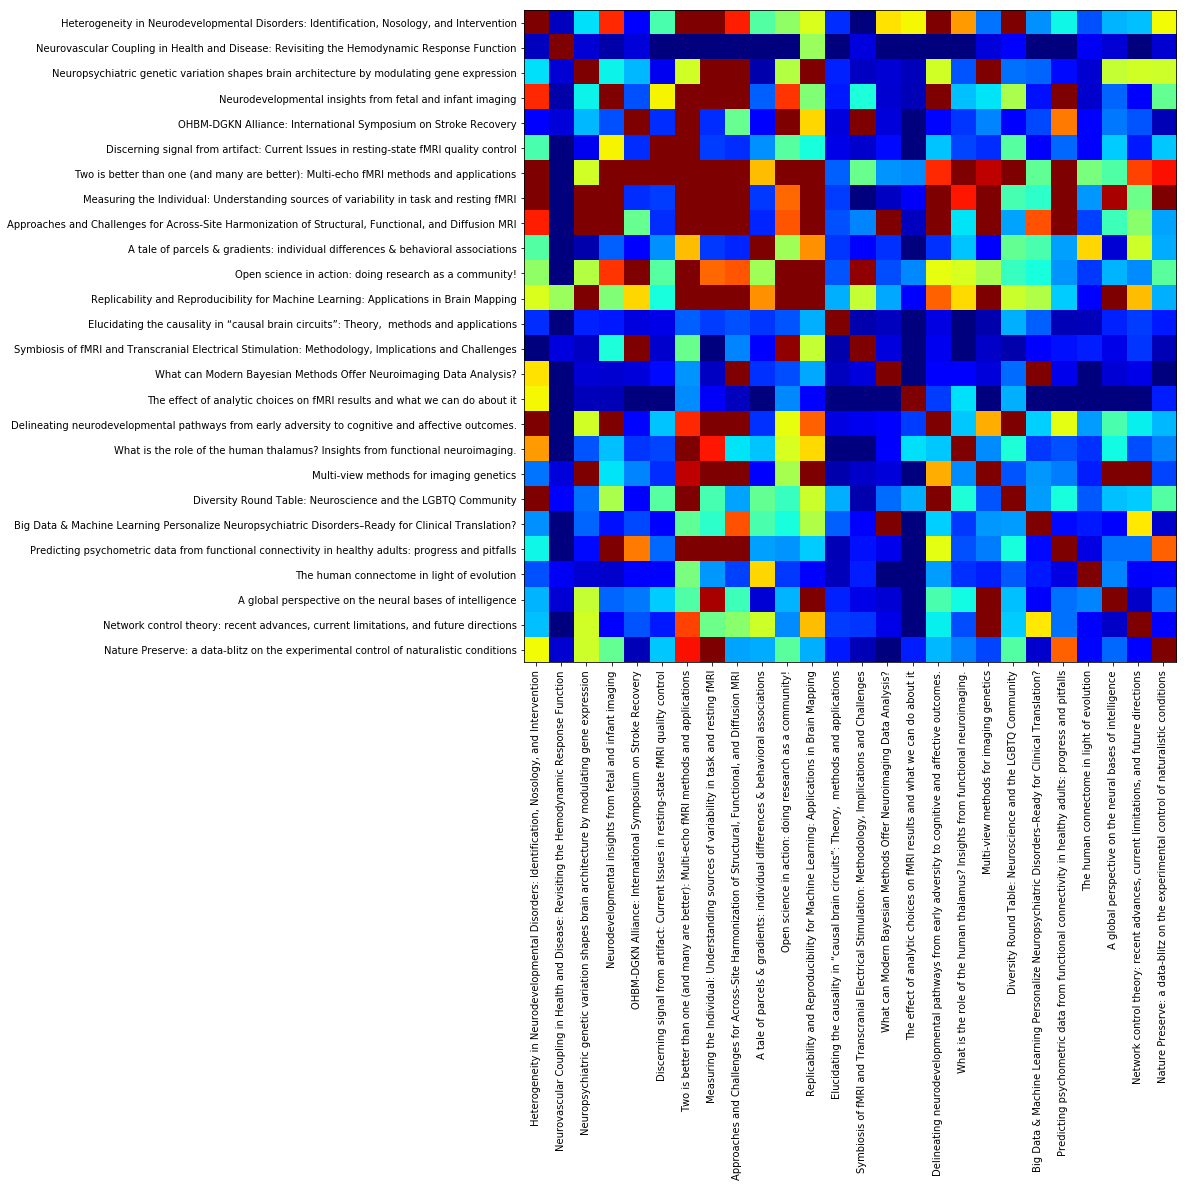

In [247]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig = plt.figure(figsize=(12,12))
plt.imshow(mat, interpolation='nearest', cmap=cm.jet, vmax=0.05)
ax = plt.gca()
ax.set_yticks(np.arange(0, len(panel_titles), 1))
ax.set_xticks(np.arange(0, len(panel_titles), 1))
ax.set_yticklabels(panel_titles)
ax.set_xticklabels(panel_titles)
plt.xticks(rotation=90)
plt.show()